# Deep Learning with PyTorch : Build a Generative Adversarial Network

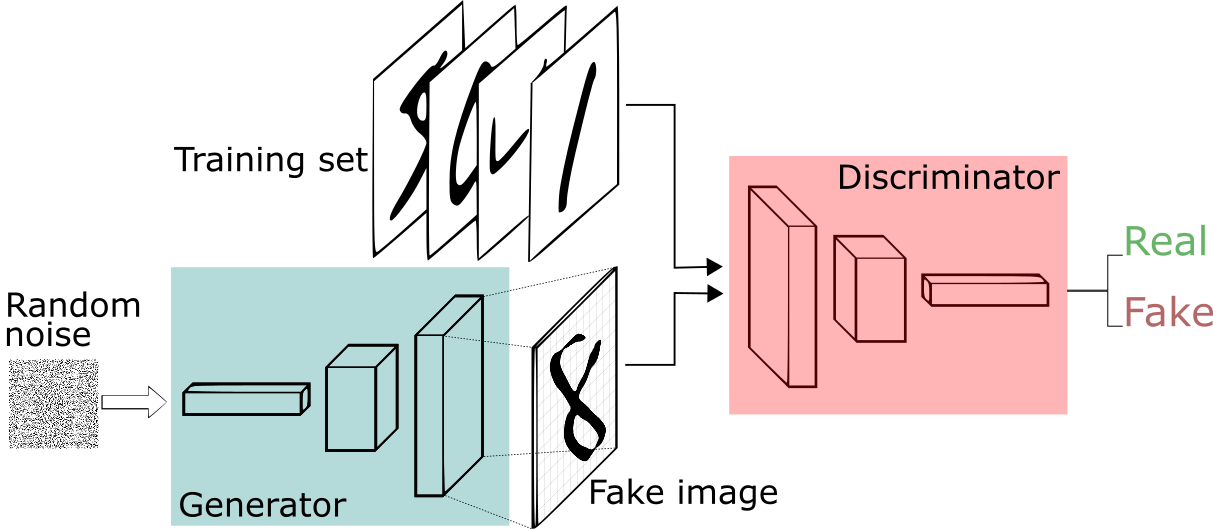

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cuda' #Image = Image.to(device)

batch_size = 128 #trainloader.training loop

noise_dim = 64 #Generator Model

# optimization parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

#Training variable
epochs = 100

# Load MNIST Dataset

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([

                           T.RandomRotation((-20 , +20)),

                           T.ToTensor() #(h, w, c) -> (c, h, w)


])

In [5]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]


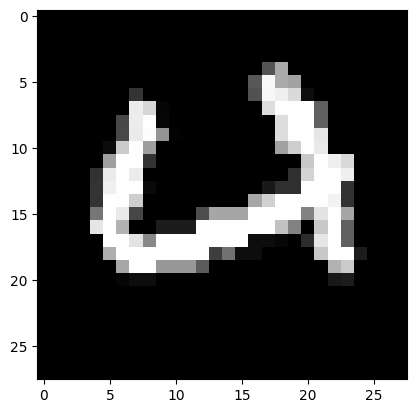

In [6]:
image, label = trainset[60]

plt.imshow(image.squeeze(), cmap = 'gray')
plt.show()

In [7]:
print("Total images present in trainset are : ", len(trainset))

Total images present in trainset are :  60000


# Load Dataset Into Batches

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [10]:
print("Total no. of batches in trainloader : ", len(trainloader))

Total no. of batches in trainloader :  469


In [11]:
dataiter = iter(trainloader)

images, _ = next(dataiter)

print(images.shape)

torch.Size([128, 1, 28, 28])


In [12]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

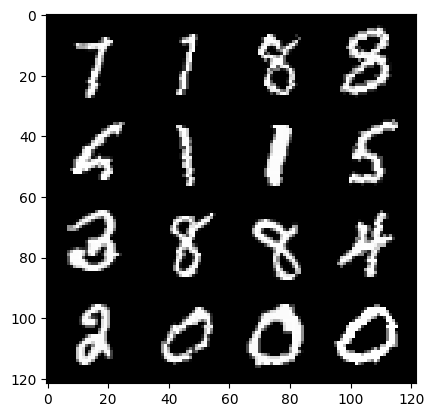

In [13]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

In [14]:
import torch.nn as nn
from torchsummary import summary

In [15]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [16]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )

  return nn.Sequential(

      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(0.2)

)

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

In [18]:
D = Discriminator()
D.to(device)
summary(D, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [19]:
'''

Network : Generator
noise_dim : 64

input : (bs, noise_dim)

        |
        | Reshape
        V

input : (bs, channel, height, width) -> (bs, 64, 1, 1)

convTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)
BatchNorm2d()
ReLU()

convTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)
BatchNorm2d()
ReLU()

convTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)
BatchNorm2d()
ReLU()

convTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)
BatchNorm2d()
ReLU()

'''

'\n\nNetwork : Generator\nnoise_dim : 64\n\ninput : (bs, noise_dim)\n\n        |\n        | Reshape\n        V\n\ninput : (bs, channel, height, width) -> (bs, 64, 1, 1)\n\nconvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)\nBatchNorm2d()\nReLU()\n\nconvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)\nBatchNorm2d()\nReLU()\n\nconvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)\nBatchNorm2d()\nReLU()\n\nconvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)\nBatchNorm2d()\nReLU()\n\n'

In [23]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False ):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )

  return nn.Sequential(

      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(0.2)

)

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
        self.block_2 = get_gen_block(256, 128, (4,4), 1)
        self.block_3 = get_gen_block(128, 64, (3,3), 2)
        self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

    def forward(self, r_noise_vec):

        #(bs, noise dim) -> (bs, noise dim, 1,1)
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

        x = self.block_1(x)
        x2 = self.block_2(x)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)

        return x4

In [24]:
G = Generator()
G.to(device)
summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [25]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [26]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [27]:
#Defining loss function

def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [28]:
#loading optimizers, We have used Adam optimiser
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas = (beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.6855872206088068  | G_loss : 0.6895555560268573


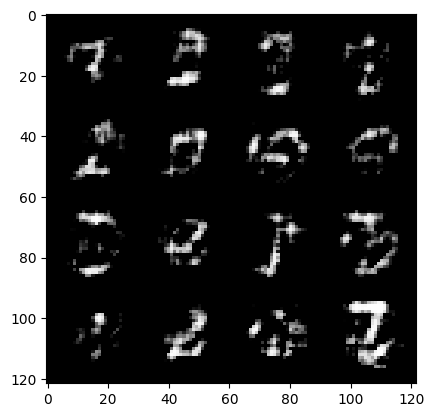

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.6767476245538512  | G_loss : 0.7129985180490815


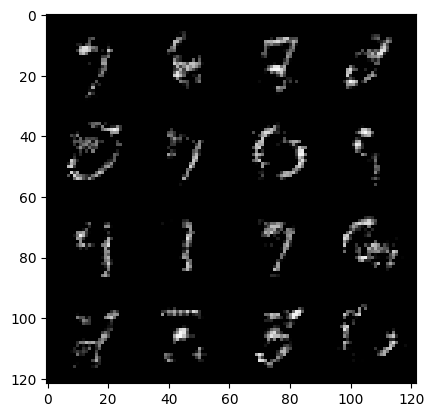

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.6359442359348858  | G_loss : 0.758728996777077


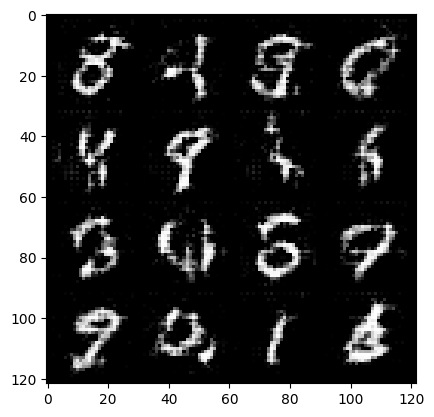

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.6172129600795347  | G_loss : 0.7888014367394356


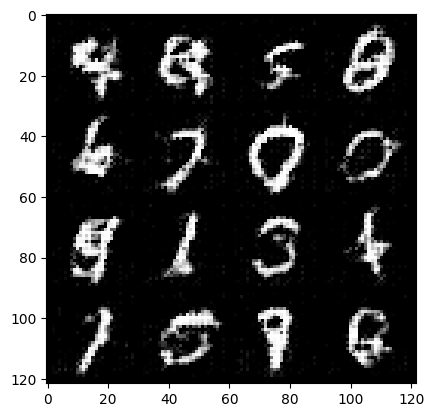

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.609792044040745  | G_loss : 0.8105413299887928


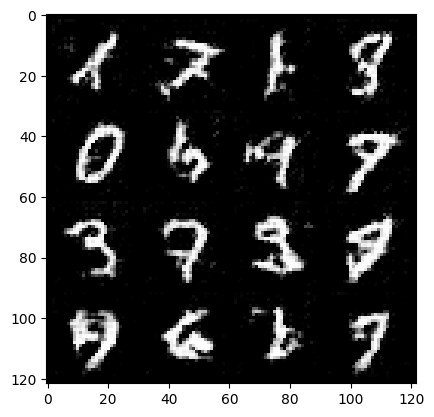

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.6083453959747672  | G_loss : 0.8257230198713762


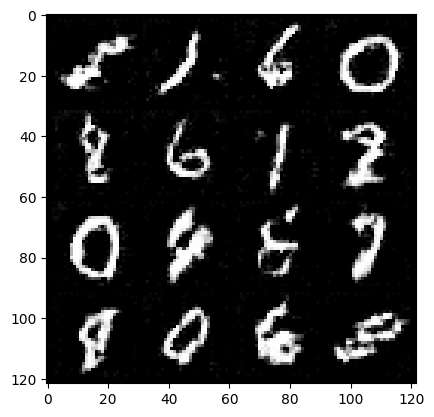

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.6186268668947443  | G_loss : 0.8188294786125866


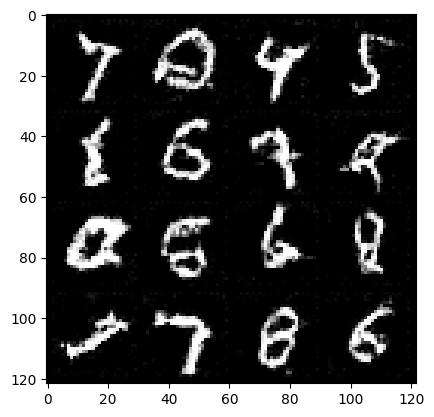

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.626337087103553  | G_loss : 0.8145515855187292


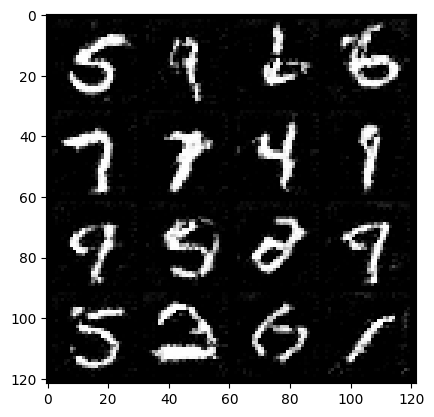

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.6295795368233215  | G_loss : 0.8152449240308326


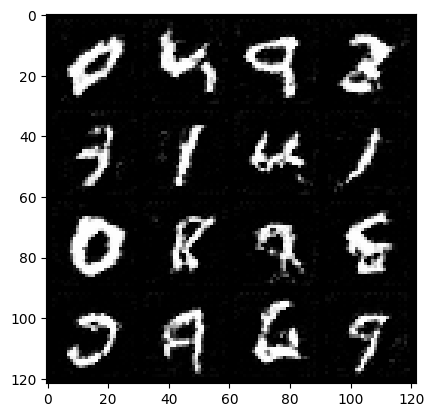

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.6318514763927663  | G_loss : 0.8142603733646336


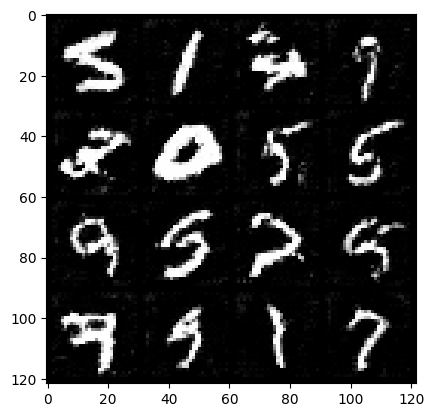

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.6357658694802063  | G_loss : 0.8103245834806072


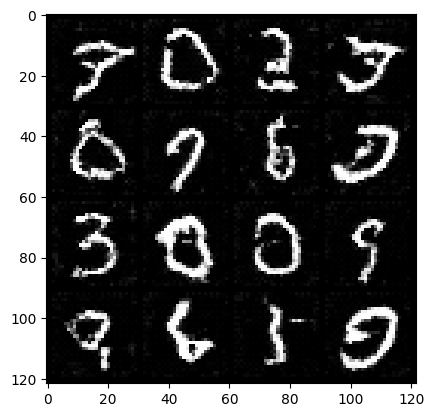

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.6387040226190075  | G_loss : 0.8114397828258685


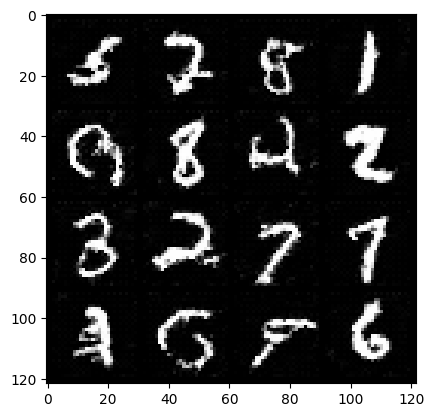

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.6401753078645734  | G_loss : 0.8087168185949833


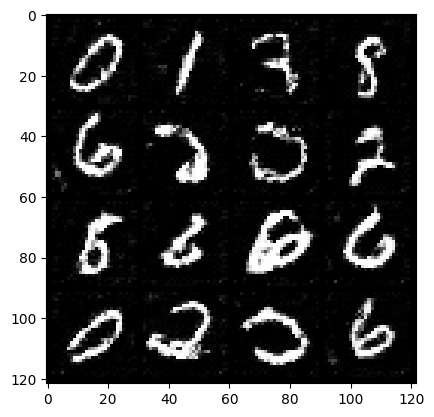

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.6435861231675789  | G_loss : 0.8032507396964376


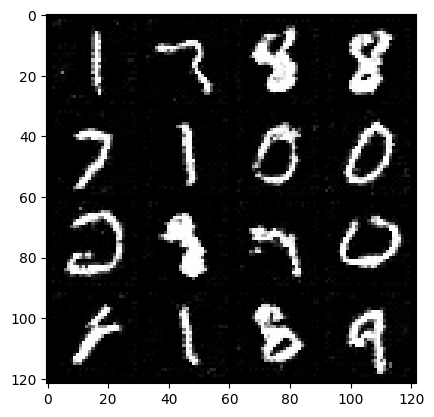

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.6455802100299518  | G_loss : 0.803346329025114


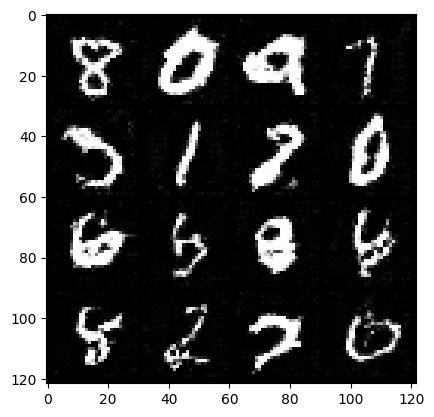

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.6452128094142434  | G_loss : 0.8029861084179584


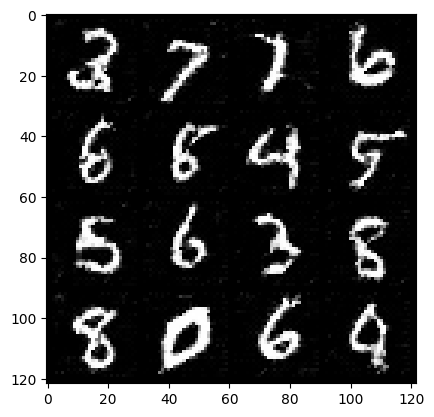

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.6449469062311055  | G_loss : 0.8029202733721051


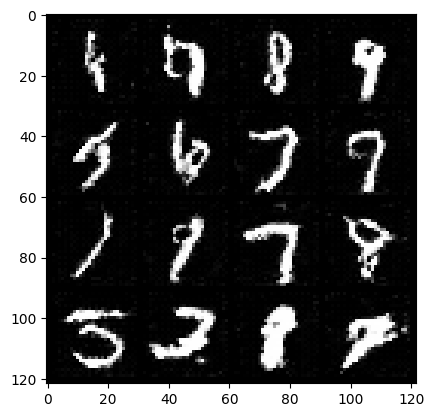

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.6463030394968956  | G_loss : 0.8025393613111744


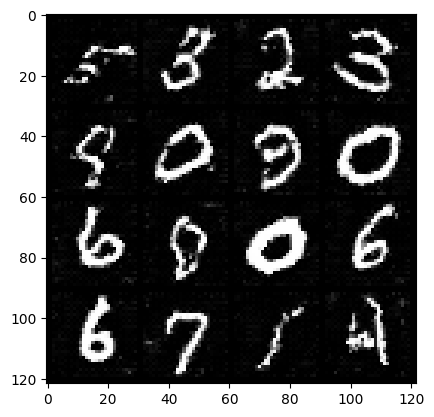

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.6474089991055063  | G_loss : 0.8021476644951143


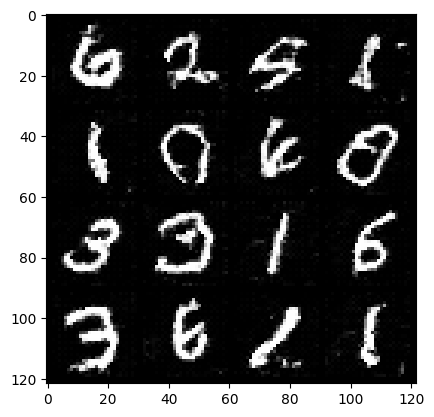

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.649545947117592  | G_loss : 0.8003302041147309


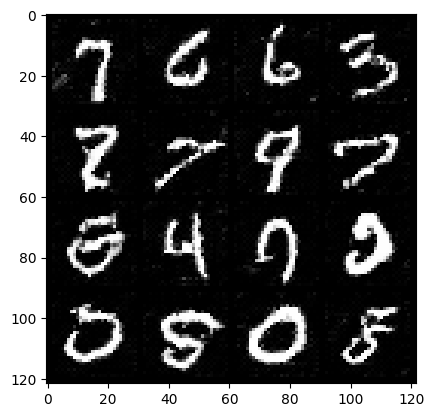

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 21 | D_loss : 0.6486627341333483  | G_loss : 0.7999362569373808


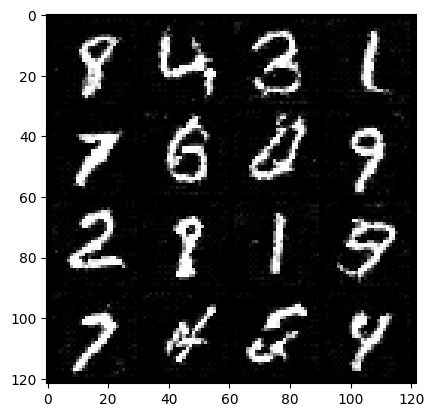

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 22 | D_loss : 0.6486015774802104  | G_loss : 0.8010627162227753


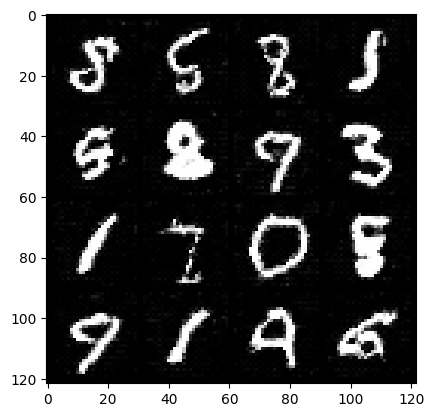

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 23 | D_loss : 0.649185468393094  | G_loss : 0.8021253925650867


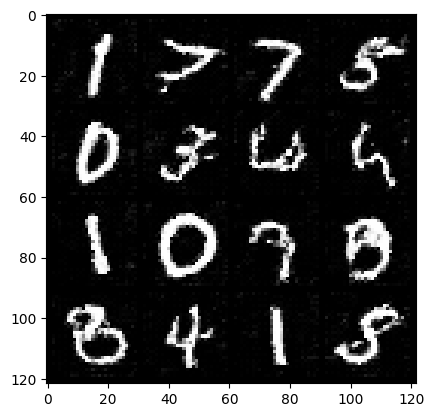

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 24 | D_loss : 0.649882381912996  | G_loss : 0.7997592856634909


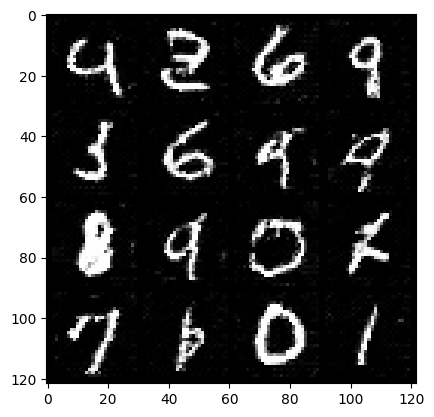

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 25 | D_loss : 0.6503666434715043  | G_loss : 0.797763513857876


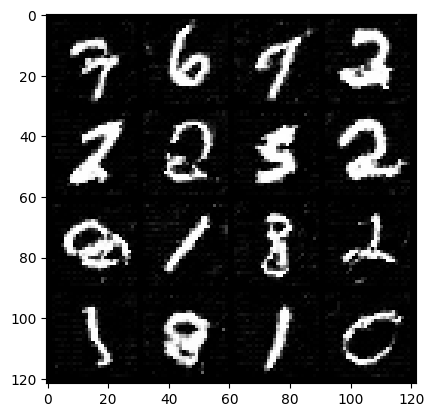

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 26 | D_loss : 0.6511318992450039  | G_loss : 0.8000517322310506


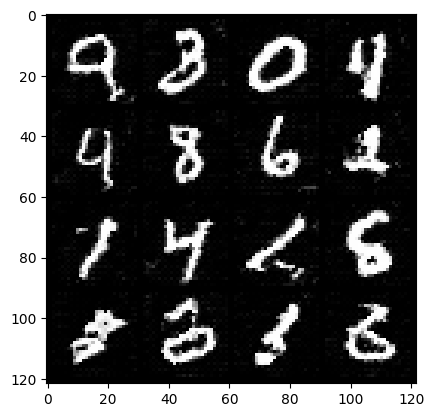

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 27 | D_loss : 0.6474814315848767  | G_loss : 0.80524894982767


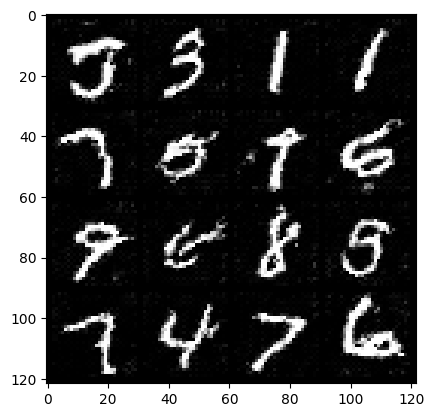

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 28 | D_loss : 0.6460294342244358  | G_loss : 0.8072778507590548


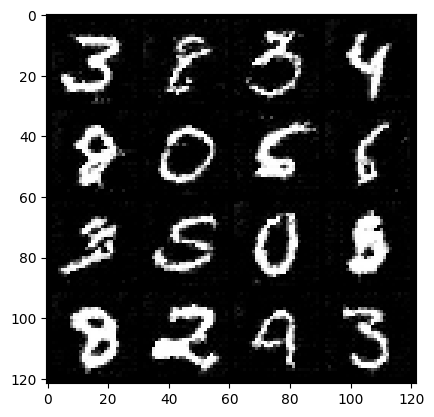

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 29 | D_loss : 0.644746451362618  | G_loss : 0.81366164521622


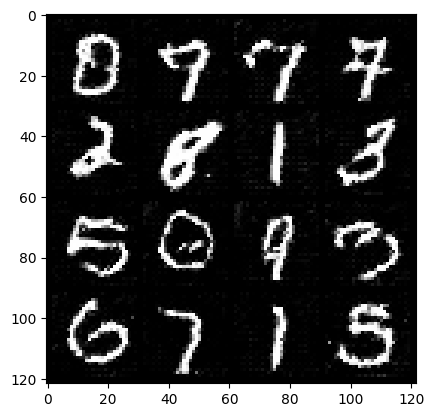

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 30 | D_loss : 0.6451413565353036  | G_loss : 0.8162935311352012


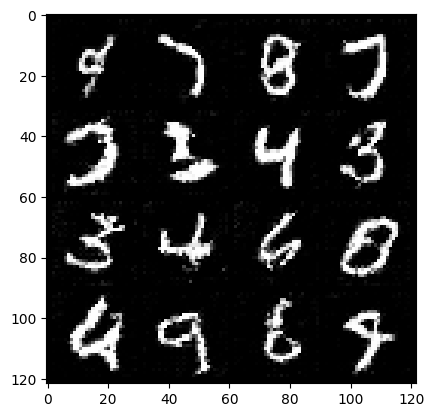

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 31 | D_loss : 0.6429629581315177  | G_loss : 0.8170551406040883


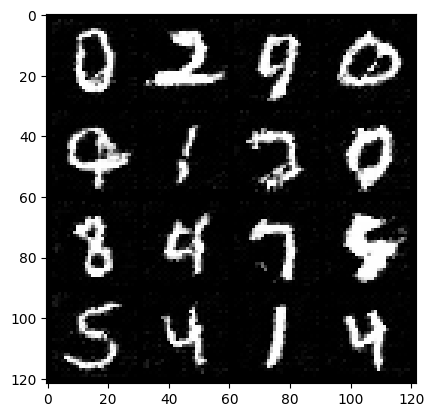

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 32 | D_loss : 0.6440502391186859  | G_loss : 0.8193511560019145


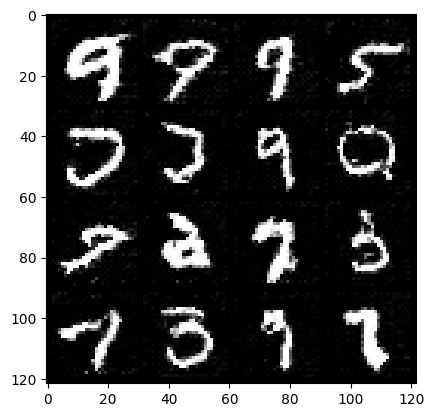

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 33 | D_loss : 0.6414679128732255  | G_loss : 0.8218556491296682


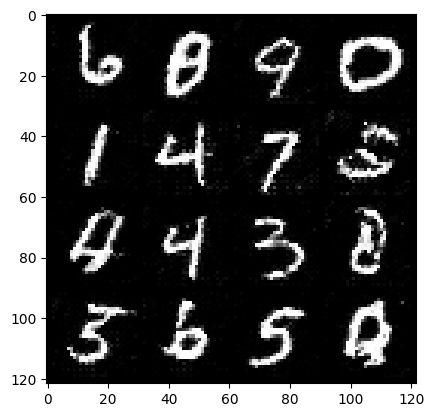

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 34 | D_loss : 0.6400910209236877  | G_loss : 0.8262366395769343


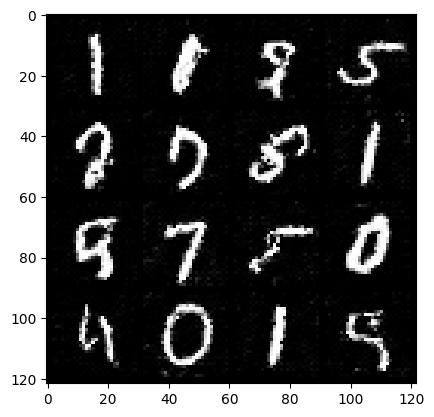

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 35 | D_loss : 0.639840581778016  | G_loss : 0.824449279160896


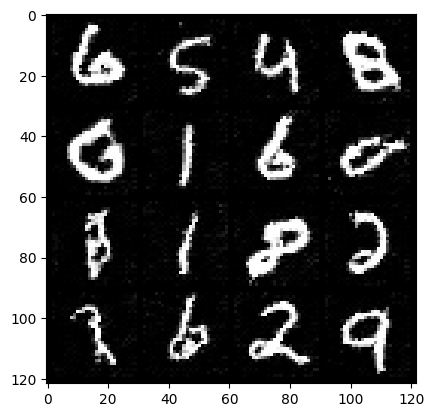

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 36 | D_loss : 0.6401773763617982  | G_loss : 0.8255197349896055


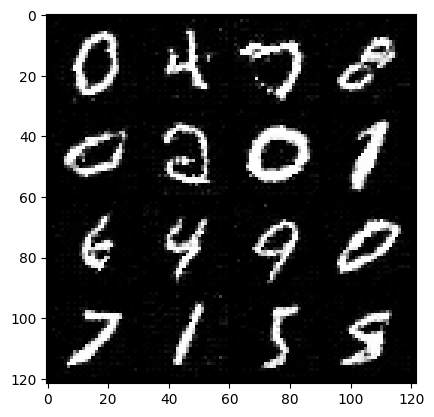

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 37 | D_loss : 0.6401716363963796  | G_loss : 0.8304712244950886


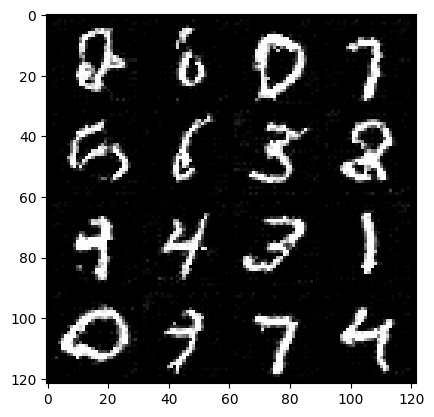

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 38 | D_loss : 0.6384669510540424  | G_loss : 0.8347703177791669


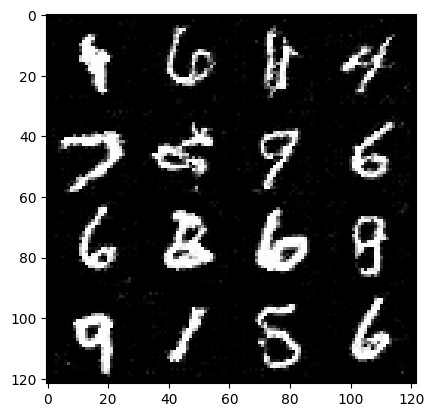

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 39 | D_loss : 0.6370493792521674  | G_loss : 0.8371553835329979


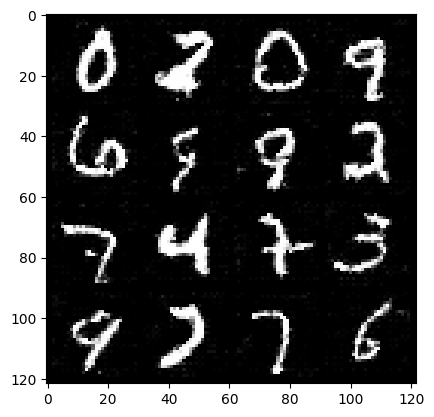

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 40 | D_loss : 0.6359978258482683  | G_loss : 0.8382150312222397


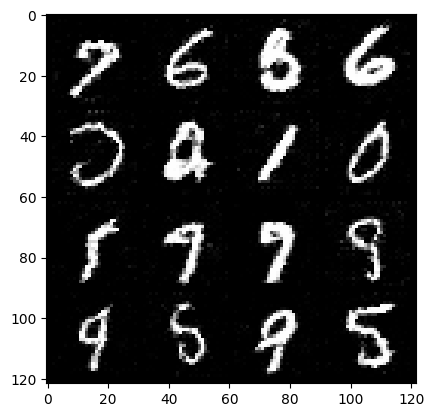

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 41 | D_loss : 0.6349036215719129  | G_loss : 0.8401723075777229


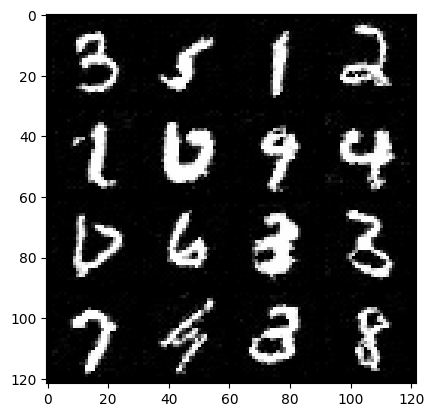

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 42 | D_loss : 0.6342696271725555  | G_loss : 0.8447807663793503


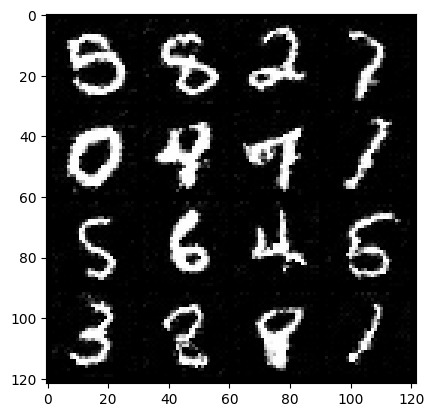

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 43 | D_loss : 0.6333189601583014  | G_loss : 0.8474489794865346


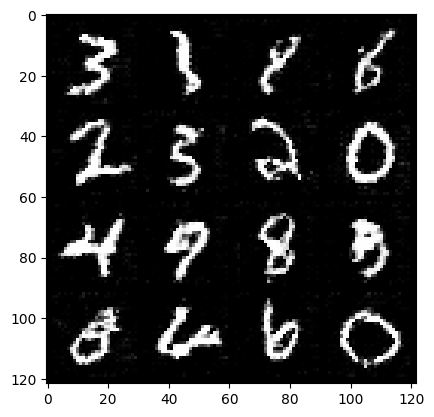

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 44 | D_loss : 0.6323910946530829  | G_loss : 0.8532905820081992


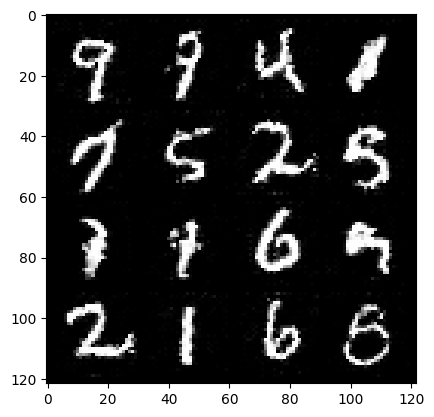

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 45 | D_loss : 0.6308976315231974  | G_loss : 0.8559828021887269


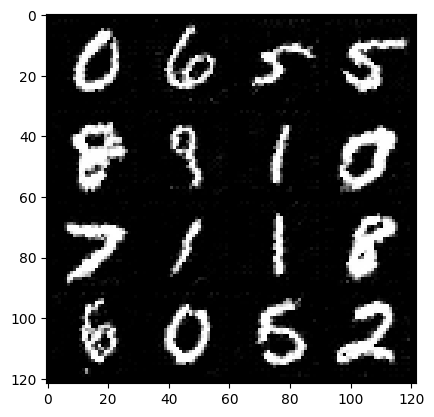

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 46 | D_loss : 0.6306639918640479  | G_loss : 0.8555806757036303


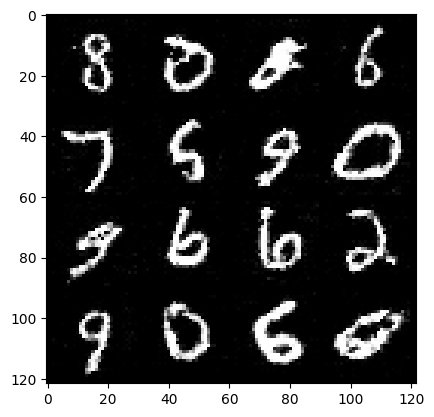

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 47 | D_loss : 0.6307337567496147  | G_loss : 0.8593488127183813


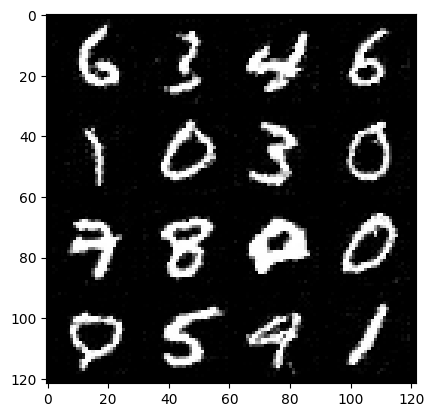

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 48 | D_loss : 0.6285402332541785  | G_loss : 0.8629507150477184


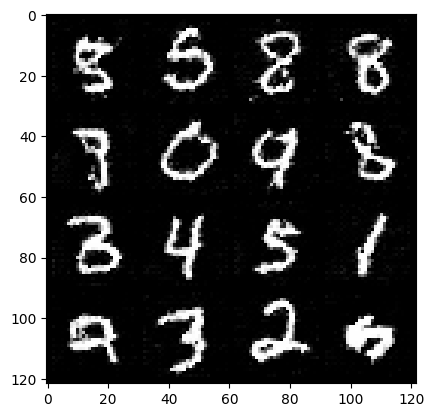

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 49 | D_loss : 0.6303992576436448  | G_loss : 0.8651578984280893


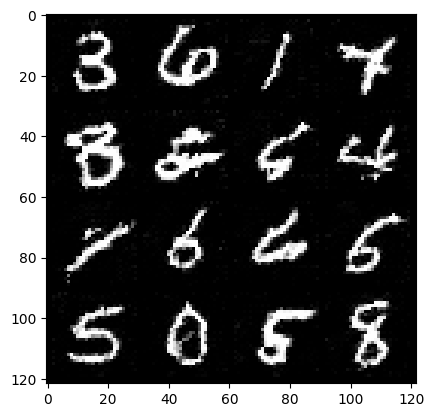

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 50 | D_loss : 0.6325729668521678  | G_loss : 0.8621269595394256


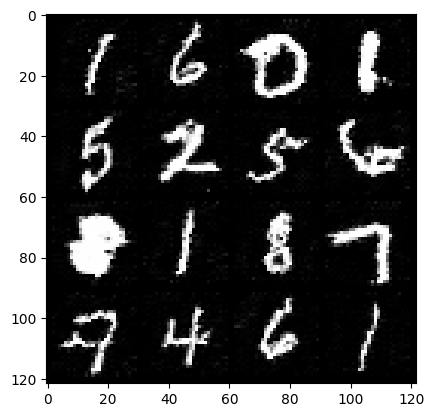

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 51 | D_loss : 0.6300205772619512  | G_loss : 0.8606406687927652


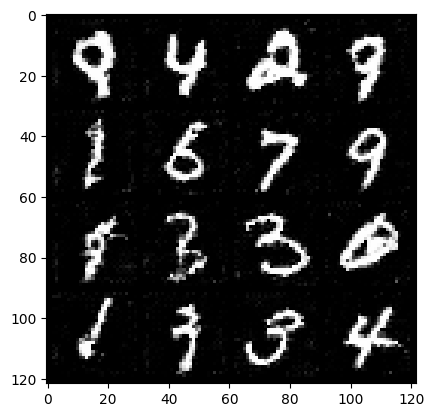

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 52 | D_loss : 0.630046433731437  | G_loss : 0.8644242320996104


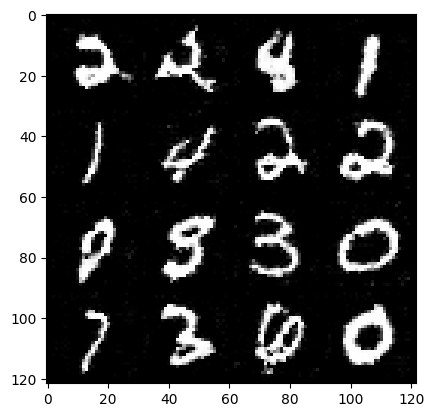

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 53 | D_loss : 0.6328111913666796  | G_loss : 0.8616817846481226


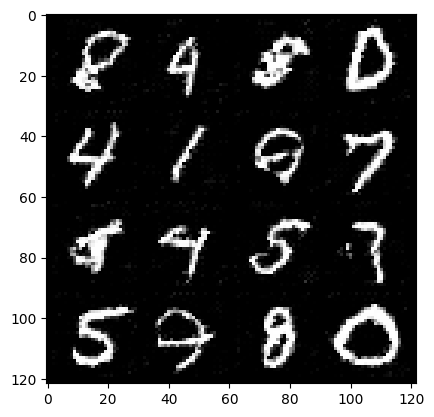

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 54 | D_loss : 0.6320369552447598  | G_loss : 0.8631481520656837


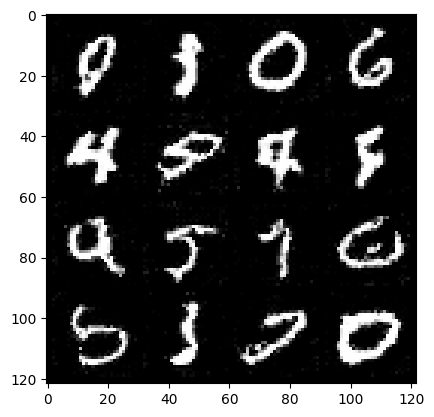

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 55 | D_loss : 0.6329849247993437  | G_loss : 0.8625112816468993


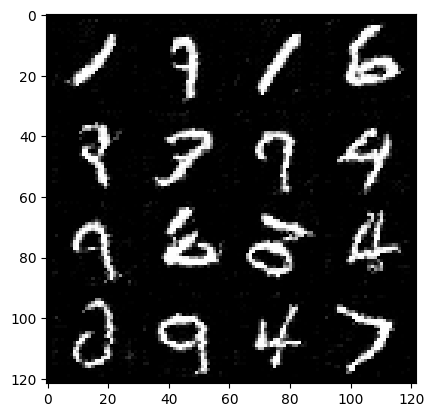

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 56 | D_loss : 0.6324136643521567  | G_loss : 0.8621877430598619


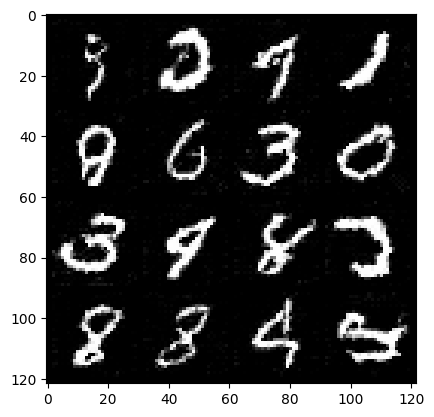

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm (trainloader):
    real_img = real_img.to(device)

    #find loss and update weights for D
    D_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device) # Define noise here
    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    #find loss ad update for Generator G
    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device)
    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)
    total_g_loss += G_loss.item()
    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/ len(trainloader)
  print("Epoch : {} | D_loss : {}  | G_loss : {}".format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

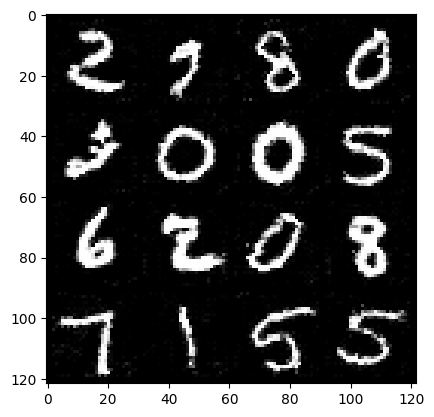

In [30]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

**Building a Generative Adversarial Network**

Belongs to - Chandrabhushan Upadhyay

contact me at - chandr4243@gmail.com



